# Using LSTM


In [1]:
#importing the libraries
import torch
from torchtext import data
import numpy as np
import torch.nn.functional as F

#fixing seed
SEED = 1234 

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

#imprting spacy for text processing
import spacy

TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField(dtype=torch.float)

#importing imdb dataset
from torchtext.datasets import IMDB

#splitting into test and train
train_data, test_data = IMDB.splits(TEXT,LABEL)

In [3]:
# print an example
print(vars(train_data.examples[6]))

{'text': ['I', 'am', 'stunned', 'at', 'the', 'negative', 'comments', 'that', 'I', 'have', 'read', 'and', 'can', 'only', 'assume', 'that', 'the', 'people', 'making', 'such', 'comments', 'were', 'less', 'than', 'honest', '.', 'This', 'is', 'the', 'most', 'moving', 'and', 'real', 'portrayal', 'of', 'Joseph', 'Smith', 'that', 'I', 'have', 'ever', 'seen', '.', 'It', 'was', 'well', 'acted', 'to', 'the', 'point', 'that', 'at', 'times', 'I', 'forgot', 'that', 'I', 'was', 'watching', 'a', 'movie', '.', 'It', 'brought', 'Joseph', "'s", 'life', 'of', 'hardship', ',', 'good', '-', 'natured', 'optimism', ',', 'enduring', 'faith', 'in', 'people', 'and', 'God', ',', 'and', 'ultimate', 'sacrifice', 'to', 'life', 'such', 'in', 'a', 'way', 'that', 'frankly', 'left', 'me', 'speechless', 'and', 'silent', 'in', 'awe', '.', 'If', 'anyone', ',', 'of', 'ANY', 'Christian', 'religion', 'can', 'watch', 'this', 'movie', 'without', 'being', 'touched', 'in', 'some', 'positive', 'way', '--', 'I', 'would', 'have', 't

In [4]:
#build validation data
import random
train_data, valid_data = train_data.split(random_state=random.seed(SEED))

In [5]:
#build vocabulary
TEXT.build_vocab(train_data, max_size=25000)
LABEL.build_vocab(train_data)

In [7]:
#check the length of each of the dataset
print("Length of Training Data set:",len(train_data))
print("Length of test Data set:",len(test_data))
print("Length of Validation Data set:",len(valid_data))

Length of Training Data set: 17500
Length of test Data set: 25000
Length of Validation Data set: 7500


In [8]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


In [9]:
#print the most frequent words
print(TEXT.vocab.freqs.most_common(20))

[('the', 201155), (',', 190682), ('.', 165103), ('a', 109028), ('and', 108856), ('of', 100048), ('to', 93407), ('is', 75991), ('in', 61222), ('I', 54380), ('it', 53617), ('that', 49021), ('"', 44389), ("'s", 43002), ('this', 42288), ('-', 36720), ('/><br', 35753), ('was', 35036), ('as', 30362), ('with', 29639)]


In [10]:
#split the data using bucket iterator
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BPTTIterator.splits(
    (train_data, valid_data, test_data), 
    bptt_len=30,
    batch_size=BATCH_SIZE,
    device=device)

In [11]:
#Build the LSTM model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable as V
 
class RNN(nn.Module):
    def __init__(self, ntoken, ninp,
                 nhid, nlayers, bsz):
        super(RNN, self).__init__()
        self.nhid, self.nlayers, self.bsz = nhid, nlayers, bsz
        self.encoder = nn.Embedding(ntoken, ninp)
        self.rnn = nn.LSTM(ninp, nhid, nlayers)
        self.decoder = nn.Linear(nhid, ntoken)    
    
    def forward(self, input):
        emb = self.encoder(input)
        output, self.hidden = self.rnn(emb)
        output = output
        decoded = self.decoder(output.view(output.size(0)*output.size(1), output.size(2)))
        return decoded.view(output.size(0), output.size(1), decoded.size(1))


In [12]:
#pass the parameters
nwords = len(TEXT.vocab)
n_inp= 200
batch= BATCH_SIZE
n_hid=200
no_layers=1

In [13]:
model = RNN(nwords,n_inp,n_hid,no_layers,batch)

# Training the model using Adam optimizer and learning rate = 0.001

In [14]:
#cross entropy loss
criterion = nn.CrossEntropyLoss()
#optimize using Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.7, 0.99))

model=model.to(device)
criterion=criterion.to(device)



import time
from tqdm import tqdm

#train the model

def train_epoch(epoch):

    epoch_loss = 0
    model.train()
    average_time = 0
    for batch in tqdm(train_iterator):
    
        batch_time = time.time()
#         print(batch_time)
        optimizer.zero_grad()

        text, targets = batch.text, batch.target
        prediction = model(text)
        
        loss = criterion(prediction.view(-1, nwords), targets.view(-1))
        loss.backward()

        optimizer.step()
        
        batch_time = time.time() - batch_time
        
        average_time += batch_time
#         print(average_time)
        epoch_loss += loss.item()
        epoch_loss /= len(train_data.examples[0].text)
        loss_history[epoch] = loss
        
    # log the loss for each of the iterations
    val_loss = 0
    model.eval()
    for batch in valid_iterator:
        #model.reset_history()
        text, targets = batch.text, batch.target
        prediction = model(text)
        loss = criterion(prediction.view(-1, nwords), targets.view(-1))
        val_loss += loss.item()
    val_loss /= len(valid_data.examples[0].text)
 
    print('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}, Batch time: {:.4f}'.format(epoch, epoch_loss, val_loss, average_time))
    return epoch_loss , val_loss , average_time


In [15]:
n_epochs = 10
loss_history = np.arange(0,n_epochs,dtype=float)
time_history = np.arange(0,n_epochs,dtype=float)
for epoch in range(1, n_epochs):
  train_loss, val_loss, train_time = train_epoch(epoch)
  loss_history[epoch] = train_loss
  time_history[epoch] = train_time

100%|██████████| 1/1 [00:00<00:00, 121.62it/s]

Epoch: 1, Training Loss: 0.0271, Validation Loss: 0.0228, Batch time: 0.0051
Epoch: 2, Training Loss: 0.0269, Validation Loss: 0.0228, Batch time: 0.0019
Epoch: 3, Training Loss: 0.0268, Validation Loss: 0.0228, Batch time: 0.0016
Epoch: 4, Training Loss: 0.0266, Validation Loss: 0.0227, Batch time: 0.0015
Epoch: 5, Training Loss: 0.0264, Validation Loss: 0.0227, Batch time: 0.0015
Epoch: 6, Training Loss: 0.0262, Validation Loss: 0.0227, Batch time: 0.0015
Epoch: 7, Training Loss: 0.0260, Validation Loss: 0.0227, Batch time: 0.0016
Epoch: 8, Training Loss: 0.0258, Validation Loss: 0.0226, Batch time: 0.0016
Epoch: 9, Training Loss: 0.0256, Validation Loss: 0.0226, Batch time: 0.0016


Text(0.5, 1.0, 'time_vs_epoch')

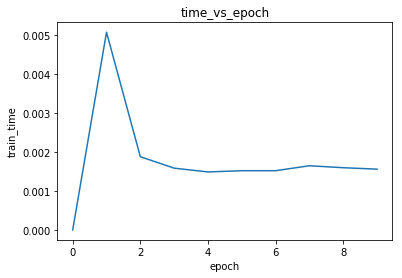

In [17]:
import matplotlib.pyplot as plt
plt.plot(np.arange(0,n_epochs),time_history)
# plt.ylim(0.0000, 0.0170)
plt.xlabel('epoch')
plt.ylabel('train_time')
plt.title('time_vs_epoch')

Text(0.5, 1.0, 'loss_vs_epoch')

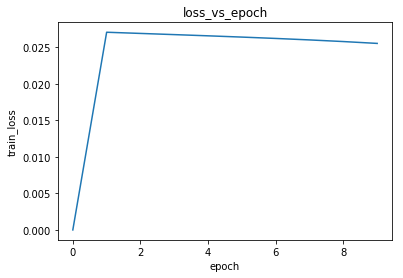

In [18]:
import matplotlib.pyplot as plt
plt.plot(np.arange(0,n_epochs),loss_history)
# plt.ylim(0.00000130, 0.00000200)
plt.xlabel('epoch')
plt.ylabel('train_loss')
plt.title('loss_vs_epoch')

# Key design choices and their impact on training time and generative quality

Below, we have tried multiple iterations using different optmizers and learning rate. We see that Adam optimizer which we tried originally earlier gives best results

# a. Training using RMSprop and learning rate = 0.0001

In [17]:
model1 = RNN(nwords,n_inp,n_hid,no_layers,batch)

#cross entropy loss
criterion = nn.CrossEntropyLoss()
#optimize using Adam optimizer
optimizer = optim.RMSprop(model1.parameters(), lr=0.0001)

model1=model1.to(device)
criterion=criterion.to(device)



import time
from tqdm import tqdm

#train the model

def train_epoch(epoch):

    epoch_loss = 0
    model1.train()
    average_time = 0
    for batch in tqdm(train_iterator):
    
        batch_time = time.time()
#         print(batch_time)
        optimizer.zero_grad()

        text, targets = batch.text, batch.target
        prediction = model1(text)
        
        loss = criterion(prediction.view(-1, nwords), targets.view(-1))
        loss.backward()

        optimizer.step()
        
        batch_time = time.time() - batch_time
        
        average_time += batch_time
#         print(average_time)
        epoch_loss += loss.item()
        epoch_loss /= len(train_data.examples[0].text)
        loss_history[epoch] = loss
        
    # log the loss for each of the iterations
    val_loss = 0
    model1.eval()
    for batch in valid_iterator:
        #model.reset_history()
        text, targets = batch.text, batch.target
        prediction = model1(text)
        loss = criterion(prediction.view(-1, nwords), targets.view(-1))
        val_loss += loss.item()
    val_loss /= len(valid_data.examples[0].text)
 
    print('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}, Batch time: {:.4f}'.format(epoch, epoch_loss, val_loss, average_time))
    return epoch_loss , val_loss , average_time 


In [18]:
n_epochs = 10
loss_history = np.arange(0,n_epochs,dtype=float)
time_history = np.arange(0,n_epochs,dtype=float)
for epoch in range(1, n_epochs):
  train_loss, val_loss, train_time = train_epoch(epoch)
  loss_history[epoch] = train_loss
  time_history[epoch] = train_time

100%|██████████| 1/1 [00:00<00:00, 130.04it/s]

Epoch: 1, Training Loss: 0.0271, Validation Loss: 0.0228, Batch time: 0.0016
Epoch: 2, Training Loss: 0.0269, Validation Loss: 0.0228, Batch time: 0.0020
Epoch: 3, Training Loss: 0.0268, Validation Loss: 0.0228, Batch time: 0.0016
Epoch: 4, Training Loss: 0.0267, Validation Loss: 0.0228, Batch time: 0.0016
Epoch: 5, Training Loss: 0.0266, Validation Loss: 0.0228, Batch time: 0.0013
Epoch: 6, Training Loss: 0.0266, Validation Loss: 0.0227, Batch time: 0.0013
Epoch: 7, Training Loss: 0.0265, Validation Loss: 0.0227, Batch time: 0.0014
Epoch: 8, Training Loss: 0.0264, Validation Loss: 0.0227, Batch time: 0.0014
Epoch: 9, Training Loss: 0.0263, Validation Loss: 0.0227, Batch time: 0.0014


Text(0.5, 1.0, 'time_vs_epoch')

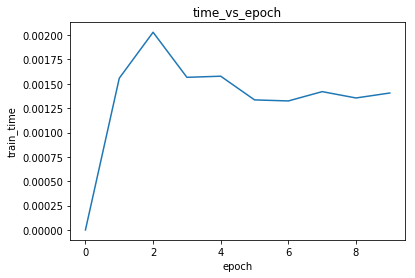

In [19]:
import matplotlib.pyplot as plt
plt.plot(np.arange(0,n_epochs),time_history)
# plt.ylim(0.0000, 0.0170)
plt.xlabel('epoch')
plt.ylabel('train_time')
plt.title('time_vs_epoch')

Text(0.5, 1.0, 'loss_vs_epoch')

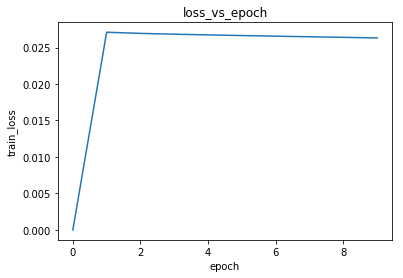

In [20]:
import matplotlib.pyplot as plt
plt.plot(np.arange(0,n_epochs),loss_history)
# plt.ylim(0.00000130, 0.00000200)
plt.xlabel('epoch')
plt.ylabel('train_loss')
plt.title('loss_vs_epoch')

# b. Training using SGD and learning rate = 0.01

In [19]:
model2 = RNN(nwords,n_inp,n_hid,no_layers,batch)

#cross entropy loss
criterion = nn.CrossEntropyLoss()
#optimize using Adam optimizer
optimizer = optim.SGD(model2.parameters(), lr=0.01)

model2=model2.to(device)
criterion=criterion.to(device)



import time
from tqdm import tqdm

#train the model

def train_epoch(epoch):

    epoch_loss = 0
    model2.train()
    average_time = 0
    for batch in tqdm(train_iterator):
    
        batch_time = time.time()
#         print(batch_time)
        optimizer.zero_grad()

        text, targets = batch.text, batch.target
        prediction = model2(text)
        
        loss = criterion(prediction.view(-1, nwords), targets.view(-1))
        loss.backward()

        optimizer.step()
        
        batch_time = time.time() - batch_time
        
        average_time += batch_time
#         print(average_time)
        epoch_loss += loss.item()
        epoch_loss /= len(train_data.examples[0].text)
        loss_history[epoch] = loss
        
    # log the loss for each of the iterations
    val_loss = 0
    model2.eval()
    for batch in valid_iterator:
        #model.reset_history()
        text, targets = batch.text, batch.target
        prediction = model2(text)
        loss = criterion(prediction.view(-1, nwords), targets.view(-1))
        val_loss += loss.item()
    val_loss /= len(valid_data.examples[0].text)
 
    print('Epoch: {}, Training Loss: {:.4f}, Validation Loss: {:.4f}, Batch time: {:.4f}'.format(epoch, epoch_loss, val_loss, average_time))
    return epoch_loss , val_loss , average_time 


In [20]:
n_epochs = 10
loss_history = np.arange(0,n_epochs,dtype=float)
time_history = np.arange(0,n_epochs,dtype=float)
for epoch in range(1, n_epochs):
  train_loss, val_loss, train_time = train_epoch(epoch)
  loss_history[epoch] = train_loss
  time_history[epoch] = train_time

100%|██████████| 1/1 [00:00<00:00, 167.91it/s]

Epoch: 1, Training Loss: 0.0271, Validation Loss: 0.0228, Batch time: 0.0011
Epoch: 2, Training Loss: 0.0271, Validation Loss: 0.0228, Batch time: 0.0011
Epoch: 3, Training Loss: 0.0271, Validation Loss: 0.0228, Batch time: 0.0011
Epoch: 4, Training Loss: 0.0271, Validation Loss: 0.0228, Batch time: 0.0011
Epoch: 5, Training Loss: 0.0271, Validation Loss: 0.0228, Batch time: 0.0010
Epoch: 6, Training Loss: 0.0271, Validation Loss: 0.0228, Batch time: 0.0010
Epoch: 7, Training Loss: 0.0271, Validation Loss: 0.0228, Batch time: 0.0010
Epoch: 8, Training Loss: 0.0271, Validation Loss: 0.0228, Batch time: 0.0010
Epoch: 9, Training Loss: 0.0271, Validation Loss: 0.0228, Batch time: 0.0010


Text(0.5, 1.0, 'time_vs_epoch')

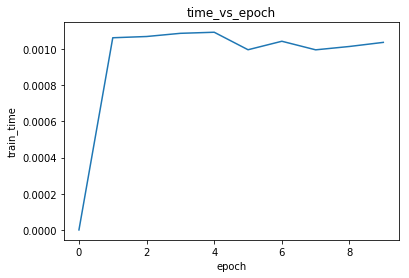

In [21]:
import matplotlib.pyplot as plt
plt.plot(np.arange(0,n_epochs),time_history)
# plt.ylim(0.0000, 0.0170)
plt.xlabel('epoch')
plt.ylabel('train_time')
plt.title('time_vs_epoch')

Text(0.5, 1.0, 'loss_vs_epoch')

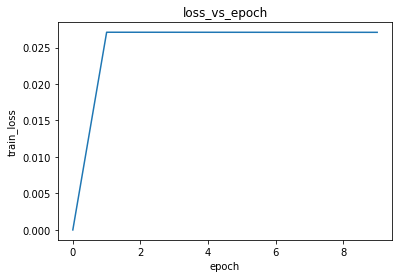

In [22]:
import matplotlib.pyplot as plt
plt.plot(np.arange(0,n_epochs),loss_history)
# plt.ylim(0.00000130, 0.00000200)
plt.xlabel('epoch')
plt.ylabel('train_loss')
plt.title('loss_vs_epoch')

# Sampling the next few words and generating the output 5 times

In all the iterations beloe we observe that outcome is different for each of the iterations

# 1st iteration

In [47]:
#building a function to generate a sequence of words
def word_ids_to_sentence(id_tensor, vocab, join=None):
    """Converts a sequence of word ids to a sentence"""
    if isinstance(id_tensor, torch.LongTensor):
        ids = id_tensor.transpose(0, 1).contiguous().view(-1)
    elif isinstance(id_tensor, np.ndarray):
        ids = id_tensor.transpose().reshape(-1)
    batch = [vocab.itos[ind] for ind in ids] # denumericalize
    if join is None:
        return batch
    else:
        return join.join(batch)

#building a function to predict tensor given an input sentence   
import spacy
nlp = spacy.load('en')

def predict_sentiment(sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    return tensor


#predicting the sequence of 20 words for the input sequence "my favourite movie"

sent_dict={}

for j in range(5):
  sentence = "My favourite movie"
  for i in range(20):
    ip= predict_sentiment(sentence)
    op=model(ip)
    op1=F.softmax(op).data
    p, top_ch=op1[-1,:,:].topk(20)
    top_ch = top_ch.cpu().data.numpy()
    p = p.cpu().data.numpy()

    #top_ch = top_ch.squeeze()
    p = p.squeeze()
    word = word_ids_to_sentence(top_ch, TEXT.vocab, join=' ')
    #word = np.random.choice(word, p=p/p.sum())

    word_1 = word.split()
    word_1 = np.random.choice(word_1, p=p/p.sum())
    sentence = sentence + ' ' + word_1

  sent_dict[j] = sentence

sent_dict[0]

/home/team2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


'My favourite movie syndicated alienating defeated woods Damien eras judgement Spark FBI ! Catch Vicky biology LESS venue paperback Abhay salute Alexis Card'

# 2nd iteration 

In [50]:
#building a function to generate a sequence of words
def word_ids_to_sentence(id_tensor, vocab, join=None):
    """Converts a sequence of word ids to a sentence"""
    if isinstance(id_tensor, torch.LongTensor):
        ids = id_tensor.transpose(0, 1).contiguous().view(-1)
    elif isinstance(id_tensor, np.ndarray):
        ids = id_tensor.transpose().reshape(-1)
    batch = [vocab.itos[ind] for ind in ids] # denumericalize
    if join is None:
        return batch
    else:
        return join.join(batch)

#building a function to predict tensor given an input sentence   
import spacy
nlp = spacy.load('en')

def predict_sentiment(sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    return tensor


#predicting the sequence of 20 words for the input sequence "my favourite movie"

sent_dict={}

for j in range(5):
  sentence = "My favourite movie"
  for i in range(20):
    ip= predict_sentiment(sentence)
    op=model(ip)
    op1=F.softmax(op).data
    p, top_ch=op1[-1,:,:].topk(20)
    top_ch = top_ch.cpu().data.numpy()
    p = p.cpu().data.numpy()

    #top_ch = top_ch.squeeze()
    p = p.squeeze()
    word = word_ids_to_sentence(top_ch, TEXT.vocab, join=' ')
    #word = np.random.choice(word, p=p/p.sum())

    word_1 = word.split()
    word_1 = np.random.choice(word_1, p=p/p.sum())
    sentence = sentence + ' ' + word_1

  sent_dict[j] = sentence

sent_dict[0]

/home/team2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


'My favourite movie kitschy secured UFO prostitution Spaceballs applaud treasure moving pond cruel spectator Transylvania Begley settled Roman dazzling condition linger bounds Brit'

# 3rd iteration

In [51]:
#building a function to generate a sequence of words
def word_ids_to_sentence(id_tensor, vocab, join=None):
    """Converts a sequence of word ids to a sentence"""
    if isinstance(id_tensor, torch.LongTensor):
        ids = id_tensor.transpose(0, 1).contiguous().view(-1)
    elif isinstance(id_tensor, np.ndarray):
        ids = id_tensor.transpose().reshape(-1)
    batch = [vocab.itos[ind] for ind in ids] # denumericalize
    if join is None:
        return batch
    else:
        return join.join(batch)

#building a function to predict tensor given an input sentence   
import spacy
nlp = spacy.load('en')

def predict_sentiment(sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    return tensor


#predicting the sequence of 20 words for the input sequence "my favourite movie"

sent_dict={}

for j in range(5):
  sentence = "My favourite movie"
  for i in range(20):
    ip= predict_sentiment(sentence)
    op=model(ip)
    op1=F.softmax(op).data
    p, top_ch=op1[-1,:,:].topk(20)
    top_ch = top_ch.cpu().data.numpy()
    p = p.cpu().data.numpy()

    #top_ch = top_ch.squeeze()
    p = p.squeeze()
    word = word_ids_to_sentence(top_ch, TEXT.vocab, join=' ')
    #word = np.random.choice(word, p=p/p.sum())

    word_1 = word.split()
    word_1 = np.random.choice(word_1, p=p/p.sum())
    sentence = sentence + ' ' + word_1

  sent_dict[j] = sentence

sent_dict[0]

/home/team2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


'My favourite movie />Its bullies zombie Fiona vivid flash DeNiro defeated Love Strombel enamored lips legitimately jet Police countryside Dublin SG1 resentment scene'

# 4th iteration

In [52]:
#building a function to generate a sequence of words
def word_ids_to_sentence(id_tensor, vocab, join=None):
    """Converts a sequence of word ids to a sentence"""
    if isinstance(id_tensor, torch.LongTensor):
        ids = id_tensor.transpose(0, 1).contiguous().view(-1)
    elif isinstance(id_tensor, np.ndarray):
        ids = id_tensor.transpose().reshape(-1)
    batch = [vocab.itos[ind] for ind in ids] # denumericalize
    if join is None:
        return batch
    else:
        return join.join(batch)

#building a function to predict tensor given an input sentence   
import spacy
nlp = spacy.load('en')

def predict_sentiment(sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    return tensor


#predicting the sequence of 20 words for the input sequence "my favourite movie"

sent_dict={}

for j in range(5):
  sentence = "My favourite movie"
  for i in range(20):
    ip= predict_sentiment(sentence)
    op=model(ip)
    op1=F.softmax(op).data
    p, top_ch=op1[-1,:,:].topk(20)
    top_ch = top_ch.cpu().data.numpy()
    p = p.cpu().data.numpy()

    #top_ch = top_ch.squeeze()
    p = p.squeeze()
    word = word_ids_to_sentence(top_ch, TEXT.vocab, join=' ')
    #word = np.random.choice(word, p=p/p.sum())

    word_1 = word.split()
    word_1 = np.random.choice(word_1, p=p/p.sum())
    sentence = sentence + ' ' + word_1

  sent_dict[j] = sentence

sent_dict[0]

/home/team2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


'My favourite movie Features rose Eglantine offending bothersome Rukh Channing ENJOY noting financial degrees par commit Mario denied sequence.<br oppose Tarzan reaches roadie'

# 5th iteration

In [53]:
#building a function to generate a sequence of words
def word_ids_to_sentence(id_tensor, vocab, join=None):
    """Converts a sequence of word ids to a sentence"""
    if isinstance(id_tensor, torch.LongTensor):
        ids = id_tensor.transpose(0, 1).contiguous().view(-1)
    elif isinstance(id_tensor, np.ndarray):
        ids = id_tensor.transpose().reshape(-1)
    batch = [vocab.itos[ind] for ind in ids] # denumericalize
    if join is None:
        return batch
    else:
        return join.join(batch)

#building a function to predict tensor given an input sentence   
import spacy
nlp = spacy.load('en')

def predict_sentiment(sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    return tensor


#predicting the sequence of 20 words for the input sequence "my favourite movie"

sent_dict={}

for j in range(5):
  sentence = "My favourite movie"
  for i in range(20):
    ip= predict_sentiment(sentence)
    op=model(ip)
    op1=F.softmax(op).data
    p, top_ch=op1[-1,:,:].topk(20)
    top_ch = top_ch.cpu().data.numpy()
    p = p.cpu().data.numpy()

    #top_ch = top_ch.squeeze()
    p = p.squeeze()
    word = word_ids_to_sentence(top_ch, TEXT.vocab, join=' ')
    #word = np.random.choice(word, p=p/p.sum())

    word_1 = word.split()
    word_1 = np.random.choice(word_1, p=p/p.sum())
    sentence = sentence + ' ' + word_1

  sent_dict[j] = sentence

sent_dict[0]

/home/team2/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


'My favourite movie camcorder milestone Kriemhild backwoods become couple broad Card lots closure meddling enhanced Blunt robbers Burt out festivals Egan MORE rendezvous'